$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
.

<img src="../3600.jpg" width=500 />

# Tutorial 4: Sequence Models

## Todays Agenda
---

- What RNNs are and how they work
- Embedding
- impplementation of basic RNN
- Sentiment analysis for movie reviews
- reading at home for LSTM and GRU, B-directional RNN and some NLP basics

## imports
---

In [19]:
# Setup
%matplotlib inline
import numpy as np
import os
import sys
import time
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")


# pytorch
import torch
import torch.nn as nn
import torchtext
import torchtext.data as data
import torchtext.datasets as datasets
import torch.nn.functional as f

In [20]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reminders and recaps
---

Last tutorial we learned about CNNs- Conv layers to perform feature extranction, and FC layers for classification.

- the convolution layers output does is not relay on the filter size, but on the input size. 
- the FC layers depend only on the input and output size.

<center><img src="resources/A-vanilla-Convolutional-Neural-Network-CNN-representation.png" width="600" /></center>

[image from](https://www.researchgate.net/figure/A-vanilla-Convolutional-Neural-Network-CNN-representation_fig2_339447623)

However, we only talked about stationary data, not about **persistent state**. 

what do we do when there is another dimention? 

<center><img src="resources/vid.gif" width="600" /></center>



Sometimes, we want to look at previus inputs and outputs

<center><img src="resources/crossing_tracking_Demo1.gif" width="600" /></center>

<center><img src="resources/rnn.gif" width="600" /></center>

## Recurrent layers
---

The idea is to produce output, like simple FC layer, but also produce a state, that we will denote by $\vec{h}_t$ (hidden state)<br>
An RNN has two inputs:

- Current sample, $\vec{x}_t \in\set{R}^{d_{i}}$.
- Previous **state**, $\vec{h}_{t-1}\in\set{R}^{d_{h}}$.

and it produces two outputs which depend on both inputs:
- Current layer output, $\vec{y}_t\in\set{R}^{d_o}$.
- Current **state**, $\vec{h}_{t}\in\set{R}^{d_{h}}$.

as such
$$
\begin{align}
\forall t \geq 0:\\
\vec{h}_t &= \varphi_h\left( \mat{W}_{hh} \vec{h}_{t-1} + \mat{W}_{xh} \vec{x}_t + \vec{b}_h\right) \\
\vec{y}_t &= \varphi_y\left(\mat{W}_{hy}\vec{h}_t + \vec{b}_y \right)
\end{align}
$$

where,
- $\vec{x}_t \in\set{R}^{d_{i}}$ is the input at time $t$.
- $\vec{h}_{t-1}\in\set{R}^{d_{h}}$ is the **hidden state** of a fixed dimension.
- $\vec{y}_t\in\set{R}^{d_o}$ is the output at time $t$.
- $\mat{W}_{hh}\in\set{R}^{d_h\times d_h}$, $\mat{W}_{xh}\in\set{R}^{d_h\times d_i}$, $\mat{W}_{hy}\in\set{R}^{d_o\times d_h}$, $\vec{b}_h\in\set{R}^{d_h}$ and $\vec{b}_y\in\set{R}^{d_o}$ are the model weights and biases.
- $\varphi_h$ and $\varphi_y$ are some non-linear functions. In many cases $\varphi_y$ is not used.


:
<img src="resources/rnn_cell.png" width="300"/>
<img src="resources/rnn_g.gif" width="300"/>



note that:
- The layer does not dependent on time
- The same layer is applied at successive time steps, propagating the hidden state.

### Modeling time-dependence

If we imagine **unrolling** a single RNN layer through time,
<center><img src="resources/rnn_unrolled.png" width="1200" /></center>


RNNs layers can be stacked to build a deep RNN model.

<center><img src="resources/rnn_layered.png" width="1200"/></center>

We can see how late outputs can now be influenced by early inputs, through the hidden state.

RNN models are very flexible in terms of input and output meaning.

### Forms of tasks we can preform now:

* One-to-one: from fixed-sized input to fixed-sized output (e.g. image classification).
* One-to-many: Sequence output (e.g. image captioning takes an image and outputs a sentence of words).
* Many-to-one: Sequence input (e.g. sentiment analysis)
* Many-to-many: Sequence input and sequence output (e.g. Machine Translation).
* Many-to-many: Synced sequence input and output (e.g. video classification where we wish to label each frame of the video).

<center><img src="resources/rnn_use_cases.jpeg" width="1200"/></center>

Forward pass seems pretty easy...<br>
What about **backpropagation** ?

## Backprop from Loss for RNN
---

<center><img src="resources/bptt.png" width="1000"></center>

**Backpropagation through time**, or BPTT

1. Loss is a sum of losses from all outputs

$$ L =\sum_{k=1}^{t}L_k $$

2. Calculate Gradient of each loss w.r.t. each parameter at each timestep

$$
\pderiv{L_t}{\mat{W}} = \sum_{k=1}^{t}
\pderiv{L_t}{\hat y_t} \cdot
\pderiv{\hat y_t}{\vec{h}_t} \cdot
\pderiv{\vec{h}_t}{\vec{h}_k} \cdot
\pderiv{\vec{h}_k}{\mat{W}}
$$

3. For each parameter, accumulate gradients from all timesteps

$$
\pderiv{L}{\mat{W_i}} = \sum_{k=1}^{t}
\pderiv{L_t}{\hat {W_i}_t}
$$


As you can see, the chain rule here can create a really long chain...
Remember the Vanishing gradients problem?

one naive way to limit the vanishing gradients problem is to trancate the gradients with a fixed lenght.
**Truncated backpropagation through time** or **TBPTT**

<center><img src="resources/tbptt.png" width="1000"></center>

### RNN Implementation

Based on the above equations, let's create a simple RNN layer  with PyTorch.

In [21]:
import torch.nn as nn

class RNNLayer(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, phi_h=torch.tanh, phi_y=torch.sigmoid):
        super().__init__()
        self.phi_h, self.phi_y = phi_h, phi_y
        
        self.fc_xh = nn.Linear(in_dim, h_dim, bias=False)
        self.fc_hh = nn.Linear(h_dim, h_dim, bias=True)
        self.fc_hy = nn.Linear(h_dim, out_dim, bias=True)
        
    def forward(self, xt, h_prev=None):
        if h_prev is None:
            h_prev = torch.zeros(xt.shape[0], self.fc_hh.in_features)
        
        ht = self.phi_h(self.fc_xh(xt) + self.fc_hh(h_prev))
        
        yt = self.fc_hy(ht)
        
        if self.phi_y is not None:
            yt = self.phi_y(yt)
        
        return yt, ht


We'll instantiate our model

In [22]:
N = 3 # batch size
in_dim, h_dim, out_dim = 1024, 10, 1

rnn = RNNLayer(in_dim, h_dim, out_dim)
rnn

RNNLayer(
  (fc_xh): Linear(in_features=1024, out_features=10, bias=False)
  (fc_hh): Linear(in_features=10, out_features=10, bias=True)
  (fc_hy): Linear(in_features=10, out_features=1, bias=True)
)

And manually "run" a few time steps

In [23]:
# t=1
x1 = torch.randn(N, in_dim, requires_grad=True) # requiring grad just for torchviz
y1, h1 = rnn(x1)
print(f'y1 ({tuple(y1.shape)}):\n{y1}')
print(f'h1 ({tuple(h1.shape)}):\n{h1}\n')

# t=2
x2 = torch.randn(N, in_dim, requires_grad=True)
y2, h2 = rnn(x2, h1)
print(f'y2 ({tuple(y2.shape)}):\n{y2}')
print(f'h2 ({tuple(h2.shape)}):\n{h2}\n')

y1 ((3, 1)):
tensor([[0.4819],
        [0.4028],
        [0.5856]], grad_fn=<SigmoidBackward>)
h1 ((3, 10)):
tensor([[-0.2590, -0.1616, -0.2057, -0.3401,  0.3149,  0.2235,  0.2404,  0.5265,
          0.3989,  0.1572],
        [-0.3304,  0.3464, -0.5787,  0.7095, -0.0218,  0.0671, -0.2577,  0.7325,
          0.1604, -0.3398],
        [-0.2100, -0.4477,  0.6644, -0.4720,  0.0551,  0.6401, -0.2490,  0.5469,
         -0.3066, -0.2985]], grad_fn=<TanhBackward>)

y2 ((3, 1)):
tensor([[0.5906],
        [0.5013],
        [0.5614]], grad_fn=<SigmoidBackward>)
h2 ((3, 10)):
tensor([[ 0.9190, -0.4307, -0.5411, -0.3046,  0.2485,  0.8902,  0.3464,  0.5446,
          0.7853, -0.4272],
        [ 0.3684, -0.7912, -0.2990,  0.4389,  0.8003,  0.8202,  0.8060,  0.2826,
          0.5571, -0.4344],
        [ 0.7946, -0.2560,  0.6325, -0.3587,  0.4913,  0.0471, -0.0600,  0.6511,
         -0.7053, -0.1652]], grad_fn=<TanhBackward>)



As usual, let's visualize the computation graph and see what happened when we used the same RNN block twice, by looking at the graph from both $y_1$ and $y_2$.

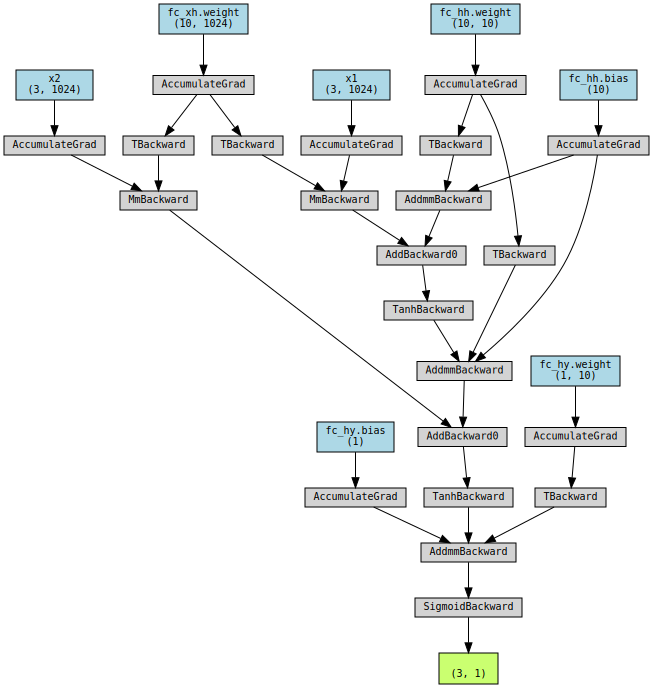

In [24]:
import torchviz

torchviz.make_dot(
    y2, # Note: Change here to y2 to see the fullly unrolled graph!
    params=dict(list(rnn.named_parameters()) + [('x1', x1), ('x2', x2)])
)

## Embedding
---

What is a **word embedding**? How do we get one?

Embeddings encode tokens as tensors in a way that maintain some **semantic** meaning for our task.

<center><img src="resources/word_embeddings.png" width="700"/></center>

brief about ways to embed:

1. Embedding Layer: We train an embeding layer with our desired size, take a long time and require a lot of data, but learn the specific relations in our corpus

2. Word2Vec: statistical method for efficiently learning a standalone word embedding from a text corpus. it's based on CBOW and C-SKIP-GRAM (basics explained in Further reading).

3. GloVe (Global Vectors for Word Representation):extension to the word2vec method for efficiently learning word vectors. using matrix factorization techniques such as Latent Semantic Analysis (LSA). if Word2Vec use a window to determine the context, GloVe used the statistics of a word to accure in the hole text.

Here we will demostrate basic Embedding

In [81]:
embedding_layer = nn.Embedding(num_embeddings=5, embedding_dim=8)

token_idx = torch.randint(low=0, high=5, size=(6,))
print(token_idx)
embedding_layer(token_idx)

tensor([4, 0, 1, 0, 1, 4])


tensor([[ 0.8127, -0.1854,  1.9355,  0.4339, -0.0432,  0.4081, -0.1311, -0.0034],
        [-1.1351, -0.4598, -1.3482, -0.9486,  0.2552, -1.1558, -0.1664, -1.3288],
        [ 0.1489, -0.3607, -1.4430, -0.3179, -0.9790,  0.2895,  0.2675, -0.5336],
        [-1.1351, -0.4598, -1.3482, -0.9486,  0.2552, -1.1558, -0.1664, -1.3288],
        [ 0.1489, -0.3607, -1.4430, -0.3179, -0.9790,  0.2895,  0.2675, -0.5336],
        [ 0.8127, -0.1854,  1.9355,  0.4339, -0.0432,  0.4081, -0.1311, -0.0034]],
       grad_fn=<EmbeddingBackward>)

## Sentiment analysis for movie reviews
---

The task: Given a review about a movie written by some user, decide whether it's **positive**, **negative** or **neutral**.

<center><img src="resources/sentiment_analysis.png" width="500" /></center>


Classically this is considered a challenging task if approached based on keywords alone.

Consider:

     "This movie was actually neither that funny, nor super witty."
     
To comprehend such a sentence, it's intuitive to see that some "state" must be kept when "reading" it.

So far we only worked with images or tabular data.
all the optimization process we lean on works with neumerical parameters, so what can we do to work with numbers again?<br>

<br>
we will use the simple folowing steps:
* Load the dataset
* Decide on tokens and tokenize our dataset (words/ chars)
* Build a vocabulary from all existing tokens
* Encode each text/sentence into sequences of numerical numerical


For the sentiment analysis task, we will use `torchtext` to accelerate the preperation process.<br>
We're goint to use IMDB dataset: this dataset contains movie reviews which are labeled as positive and negative.<br>
If you want to load other datasets or load a custom dataset: https://torchtext.readthedocs.io/en/latest/datasets.html

Denote some Special tokens:
* \<sos> - start of sentence
* \<pad> - use to pad sentences so we can load batch of sentences with diffrent lenghts.
* \<eos> - end of a sentence.
* \<unk> - for workd that doesn't come in the train set at all or if the model thinks that no word in the vocabulary is good as next word

let's check what is the encoding assigned for `else` and what word belong to the token `10`

In [25]:
review_parser = torchtext.data.Field(
    sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long,
    tokenize='spacy', tokenizer_language='en_core_web_sm'
)

# This Field object converts the text labels into numeric values (0,1,2)
label_parser = torchtext.data.Field(
    is_target=True, sequential=False, unk_token=None, use_vocab=True
)

In [26]:
# Load SST, tokenize the samples and labels
# ds_X are Dataset objects which will use the parsers to return tensors
ds_train, ds_valid, ds_test = torchtext.datasets.SST.splits(
    review_parser, label_parser, root=data_dir
)

n_train = len(ds_train)
print(f'Number of training samples: {n_train}')
print(f'Number of test     samples: {len(ds_test)}')

Number of training samples: 8544
Number of test     samples: 2210


In [27]:
for i in ([111, 4321, 7777, 0]):
    example = ds_train[i]
    label = example.label
    review = str.join(" ", example.text)
    print(f'sample {i:04d} [{label}]:\nreview: {review}\n')

sample 0111 [positive]:
review: the film aims to be funny , uplifting and moving , sometimes all at once .

sample 4321 [neutral]:
review: the most anti - human big studio picture since 3000 miles to graceland .

sample 7777 [negative]:
review: an ugly , revolting movie .

sample 0000 [positive]:
review: the rock is destined to be the 21st century 's new ` ` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean - claud van damme or steven segal .



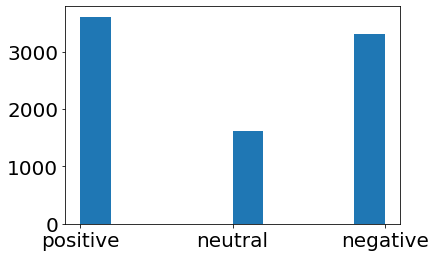

In [28]:
hist = [ds_train[i].label for i in range(len(ds_train))]
plt.hist(hist);

In [47]:
review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)
vocab = review_parser.vocab
print(f"Number of tokens in training samples: {len(review_parser.vocab)}")
print(f"Number of tokens in training labels: {len(label_parser.vocab)}")

Number of tokens in training samples: 15482
Number of tokens in training labels: 3


In [48]:
print(f'first 20 tokens:\n', review_parser.vocab.itos[:20], end='\n\n')

first 20 tokens:
 ['<unk>', '<pad>', '<sos>', '<eos>', '.', 'the', ',', 'a', 'and', 'of', 'to', '-', 'is', "'s", 'it', 'that', 'in', 'as', 'but', 'film']



In [49]:
# Show that some words exist in the vocab
for w in ['film', 'actor', 'schwarzenegger', 'spielberg']:
    print(f'word={w:15s} index={review_parser.vocab.stoi[w]}')
    
for i in [19,492,3404,715]:
    print(f'index={str(i):14} is the word ={review_parser.vocab.itos[i]}')


word=film            index=19
word=actor           index=492
word=schwarzenegger  index=3404
word=spielberg       index=715
index=19             is the word =film
index=492            is the word =actor
index=3404           is the word =schwarzenegger
index=715            is the word =spielberg


In [50]:
print(f'labels vocab:\n', dict(label_parser.vocab.stoi))

labels vocab:
 {'positive': 0, 'negative': 1, 'neutral': 2}


In [51]:
BATCH_SIZE = 4

# BucketIterator creates batches with samples of similar length
# to minimize the number of <pad> tokens in the batch.
dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
    shuffle=True, device=device)


batch = next(iter(dl_train))

X, y = batch.text, batch.label
print('X = \n', X, X.shape, end='\n\n')
print('y = \n', y, y.shape)

X = 
 tensor([[    2,     2,     2,     2],
        [   23,   140,     7,    17],
        [   12,  1011,   154,    14],
        [ 2084,    61,  2530,   411],
        [  396,    28,    41,    55],
        [    6,  2780,   350,     6],
        [   10, 10436,     6,    26],
        [   29,    10,    77,    71],
        [  400,   140,     6,   211],
        [    6,    63,   880,   358],
        [   18,     6,     6,   263],
        [   14,    66,     8,     4],
        [   13,   292,  1911,     3],
        [ 1060,   114,     4,     1],
        [   97,  3570,     3,     1],
        [   41,     5,     1,     1],
        [    8,   325,     1,     1],
        [ 7271,    46,     1,     1],
        [   20,   620,     1,     1],
        [ 1973,    21,     1,     1],
        [  388,  4526,     1,     1],
        [    4,     4,     1,     1],
        [    3,     3,     1,     1]]) torch.Size([23, 4])

y = 
 tensor([0, 1, 0, 0]) torch.Size([4])


Our sample tensor `X` is of shape `(sentence_length, batch_size)`, in our case batch is 1.

Note that:
1. `sentence_length` is fixed since we picked a max_len, otherwise it will change every batch! You can re-run the previous blocks without max_len.
2. `sentence_length` dimension first,soon you will see why

### Model

We'll now create our sentiment analysis model based on the simple `RNNLayer` we've implemented above.

embedding_layer = nn.Embedding(num_embeddings=5, embedding_dim=8)

token_idx = torch.randint(low=0, high=5, size=(6,))
print(token_idx)
embedding_layer(token_idx)The model will:
- Take an input batch of tokenized sentences.
- Compute a dense word-embedding of each token.
- Process the sentence **sequentially** through the RNN layer.
- Produce a `(B, 3)` tensor, which we'll interpret as class probabilities for each sentence in the batch.

OK, model time:

In [53]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, h_dim, out_dim):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_dim, embedding_dim)

        # Our own Vanilla RNN layer, without phi_y so it outputs a class score
        self.rnn = RNNLayer(in_dim=embedding_dim, h_dim=h_dim, out_dim=out_dim, phi_y=None)
        
        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        # X shape: (S, B) Note batch dim is not first!
        
        embedded = self.embedding(X) # embedded shape: (S, B, E)
        
        # Loop over (batch of) tokens in the sentence(s)
        ht = None
        for xt in embedded:           # xt is (B, E)
            yt, ht = self.rnn(xt, ht) # yt is (B, D_out)
        
        # Class scores to log-probability
        yt_log_proba = self.log_softmax(yt)
        
        return yt_log_proba

Let's instantiate our model.

In [54]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3

model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model

SentimentRNN(
  (embedding): Embedding(15482, 100)
  (rnn): RNNLayer(
    (fc_xh): Linear(in_features=100, out_features=128, bias=False)
    (fc_hh): Linear(in_features=128, out_features=128, bias=True)
    (fc_hy): Linear(in_features=128, out_features=3, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

Test a manual forward pass:

In [55]:
print(f'model(X) = \n', model(X), model(X).shape)
print(f'labels = ', y)

model(X) = 
 tensor([[-0.9353, -1.6935, -0.8588],
        [-1.0673, -1.6069, -0.7863],
        [-1.1683, -1.4031, -0.8136],
        [-1.1687, -1.4023, -0.8137]], grad_fn=<LogSoftmaxBackward>) torch.Size([4, 3])
labels =  tensor([0, 1, 0, 0])


How big is our model?

In [56]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The RNN model has {count_parameters(model):,} trainable weights.')

The RNN model has 1,577,899 trainable weights.


Why so many? We used only one RNN layer.

Where are most of the weights?

In [57]:
model

SentimentRNN(
  (embedding): Embedding(15482, 100)
  (rnn): RNNLayer(
    (fc_xh): Linear(in_features=100, out_features=128, bias=False)
    (fc_hh): Linear(in_features=128, out_features=128, bias=True)
    (fc_hy): Linear(in_features=128, out_features=3, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

### Training

Let's complete the example by showing the regular pytorch-style train loop with this model.

We'll run only a few epochs on a small subset just to test that it works.

In [58]:
def train(model, optimizer, loss_fn, dataloader, max_epochs=100, max_batches=200):
    for epoch_idx in range(max_epochs):
        total_loss, num_correct = 0, 0
        start_time = time.time()

        for batch_idx, batch in enumerate(dataloader):
            X, y = batch.text, batch.label

            # Forward pass
            y_pred_log_proba = model(X)

            # Backward pass
            optimizer.zero_grad()
            loss = loss_fn(y_pred_log_proba, y)
            loss.backward()

            # Weight updates
            optimizer.step()

            # Calculate accuracy
            total_loss += loss.item()
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()

            if batch_idx == max_batches-1:
                break
                
        print(f"Epoch #{epoch_idx}, loss={total_loss /(max_batches):.3f}, accuracy={num_correct /(max_batches*BATCH_SIZE):.3f}, elapsed={time.time()-start_time:.1f} sec")

In [77]:
import torch.optim as optim

rnn_model = SentimentRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)

# Recall: LogSoftmax + NLL is equiv to CrossEntropy on the class scores
loss_fn = nn.NLLLoss()

train(rnn_model, optimizer, loss_fn, dl_train, max_epochs=3) # Demo, please don't use it for your HW as is!

Epoch #0, loss=1.116, accuracy=0.388, elapsed=3.4 sec
Epoch #1, loss=1.064, accuracy=0.396, elapsed=3.5 sec
Epoch #2, loss=1.058, accuracy=0.407, elapsed=3.5 sec


In [68]:
def present_accuracy(model, dataloader,show=True):
    model.eval() # put in evaluation mode
    total_correct = 0
    total = 0
    confusion_matrix = np.zeros([3,3], int)
    with torch.no_grad():
        for data in dataloader:
            X, y = data.text.to(device), data.label.to(device)
            y_pred_log_proba = model(X)
            predicted = torch.argmax(y_pred_log_proba, dim=1)
            total += len(data)
            total_correct += (predicted == y).sum().item()
            for i, l in enumerate(y):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total * 100
    print("Test accuracy: {:.3f}%".format(model_accuracy))
    if show:
        labels = ('0','1','2')
        fig, ax = plt.subplots(1,1,figsize=(8,6))
        ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
        plt.ylabel('Actual Category')
        plt.yticks(range(3), labels)
        plt.xlabel('Predicted Category')
        plt.xticks(range(3), labels)
        plt.show()


from sklearn import metrics


def print_stats(model, dataloader):
    model.eval() # put in evaluation mode
    trues = []
    preds = []
    with torch.no_grad():
        for data in dataloader:
            X, y = data.text.to(device), data.label.to(device)
            trues+=list(y.cpu())
            y_pred_log_proba = model(X)
            predicted = torch.argmax(y_pred_log_proba, dim=1)
            preds+= list(predicted.cpu())            
    print(metrics.classification_report(trues, preds, digits=3))

Test accuracy: 41.000%


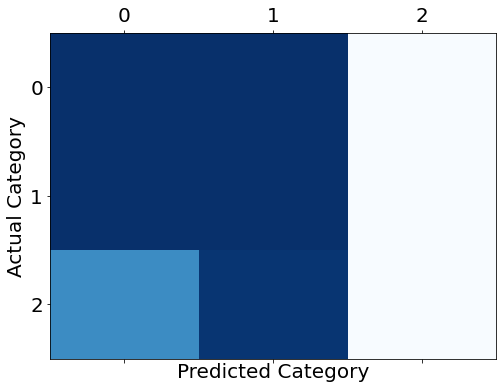

40.99953183520599

In [78]:
present_accuracy(rnn_model, dl_train)

In [79]:
print_stats(rnn_model, dl_train)

              precision    recall  f1-score   support

           0      0.445     0.426     0.435      3610
           1      0.396     0.608     0.479      3310
           2      0.000     0.000     0.000      1624

    accuracy                          0.415      8544
   macro avg      0.280     0.345     0.305      8544
weighted avg      0.341     0.415     0.370      8544



#### Limitations

As usual this is a very naïve model, just for demonstration.
It lacks many tricks of the NLP trade, such was pre-trained embeddings,
gated RNN units, deep or bi-directional models, dropout, etc.

Don't expect SotA results :)

## Further reading
---

## LSTM and GRU
---

We talked about the vanishing gradients problem with RNN, however, we didn't mention how to deal with those.
Luckyly, Gradient based methods invented long time ago...
Today we will talk about **Long Short term Memory (LSTM)** and **Gated Recurrent Unit (GRU)**. <br>

both are a type of recurrent cell that tries to preserve long term information. The idea of LSTM was presented back in 1997, but flourished in the age of deep learning.

The cell have `memory` that's base on the `state` of basic RNN and on 3 main gates: 

- Input gate: decides when to read data into the cell.
- Output gate: outputs the entries from the cell.
- Forget gate: a mechanism to reset the content of the cell.
These gates learn which information is relevant to forget or remember during the training process. The gates contain a non-linear activision function (sigmoid).


<center><img src="resources/LSTM.PNG" width="800" /></center>



you can read about the history of LSTM that originated in 1997 in [Wiki](https://en.wikipedia.org/wiki/Long_short-term_memory), however, i recomend to focus on the GRU since the math behind it designed for our perpouse and more modern.

LSTMs introduce a considerable number of additional parameters to our recurrent
networks. We now have 8 sets of weights to learn (i.e., the U and W for each of the 4
gates within each unit), whereas with simple recurrent units we only had 2. Training
these additional parameters imposes a much significantly higher training cost. **GRUs** ease this burden by dispensing with the
use of a separate context vector, and by reducing the number of gates to 2 — a reset gate, r and an update gate, z.



<center><img src="resources/GRU.png" width="600" /></center>


## BI-DIRECTIONAL RNN
---

This units solve to some degree the vanishing gradients. please note that non of them have resiliance to exploding gradients.<br>

However, we didn't talk about the problem of future context.

NLP has very complex tasks that we can't cover in this tutorial and deserve a course of itself.

However, we can think of problems such as part-of speech (POS) taging or translation. and figure that for some tasks, future input is require in order to forcast the current prediction.


"Where are you meeting him? here by the rocks, and his favorite food is roasted fox!"

"איפה אתה פוגש אותו? כאן ליד הסלעים, והאוכל האהוב עליו הוא שועל צלוי!"
<center><img src="resources/Fairuse_Gruffalo.jpg" width="200" /></center>

roasted fox start with adjective and then noun, while in hebrew it's more common to have the noun first and then the adjective. how can we translate the sentence if the hidden state does not contain the future noun?

For that we use Bi-directional RNN!
<center><img src="resources/bi.png" width="600" /></center>

## Links
---

https://nlp.stanford.edu/pubs/glove.pdf glove

**Credits**

This tutorial was written by [Aviv A. Rosenberg](https://avivr.net).<br>
To re-use, please provide attribution and link to the original.



Some images in this tutorial were taken and/or adapted from the following sources:
- http://d2l.ai
- http://giphy.com 
- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017
- Sebastian Ruder, "On word embeddings - Part 1", 2016, https://ruder.io
- http://karpathy.github.io
- Stanford cs231n
